# Classification d'image : Cassava Leaf Disease Classification

ESGI 4IADB : Cai Eddy - Taranto Tom - Sheikh Rakib - Mbae Hakim

Ce notebook développe différents modèles pour classer les images du dataset Cassava Leaf Disease Classification.

# Import

In [1]:
# Tensorflow et keras
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, MaxPool2D, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf

In [2]:
# Helper libraries
from PIL import Image
import datetime
import os
import json
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import seaborn as sn
import shutil
from random import random

In [3]:
# Pour le GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
print('TensorFlow', tf.__version__)

TensorFlow 2.2.0


## Importation du dataset

In [5]:
# Ratio split des images
validation_ratio = 0.2

In [6]:
general_path = '.'
dataset_train_folder = f"{general_path}/train"
dataset_val_folder = f"{general_path}/val"
destination_classes = [str(i) for i in range(5)]
original_train_data_folder = "./train_images"
csv_file = "./train.csv"

In [7]:
def compute_class_images_count(base_folder: str, class_name: str):
    return sum((1 for _ in os.listdir(f'{base_folder}/{class_name}')))

def compute_all_classes_images_count(base_folder: str):
    return sum((compute_class_images_count(base_folder, c) for c in destination_classes))

def compute_train_images_count():
    return compute_all_classes_images_count(dataset_train_folder)

def compute_val_images_count():
    return compute_all_classes_images_count(dataset_val_folder)

In [8]:
def clean_dataset():
    for c in destination_classes:
        folder = f'{dataset_train_folder}/{c}'
        for filename in os.listdir(folder):
            os.remove(f'{folder}/{filename}')

        folder = f'{dataset_val_folder}/{c}'
        for filename in os.listdir(folder):
            os.remove(f'{folder}/{filename}')


def clean_and_create_dataset():
    clean_dataset()
    filename_to_class_folder = {}
    with open(csv_file) as fo:
        for row in csv.reader(fo):
            filename_to_class_folder[row[0]] = row[1]

    for filename in os.listdir(original_train_data_folder):
        destination_folder = dataset_train_folder
        if random() < validation_ratio:
            destination_folder = dataset_val_folder

        shutil.copyfile(
            f'{original_train_data_folder}/{filename}',
            f'{destination_folder}/{filename_to_class_folder[filename]}/{filename}')


In [9]:
#clean_and_create_dataset()

In [10]:
data = pd.read_csv('train.csv')
data["name"] = data["label"].map(map_classes)
data['label'] = data['label'].astype('string')
data = data.sample(frac=1)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

## Exploration des données

Explorons le format de l'ensemble des données avant d'entraîner le modèle. Le tableau suivant montre qu'il y a 50 000 images dans les données d'apprentissage, chaque image étant représentée en 32 x 32 pixels:

In [ ]:
train_images.shape

De même, il y a 50 000 étiquettes dans les données d'apprentissage.

In [7]:
compute_train_images_count()

50000

Chaque étiquette est un entier compris entre 0 et 4:

In [8]:
with open(os.path.join(general_path, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
map_classes

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

Il y a 10 000 images dans les données de test. Encore une fois, chaque image est représentée par 32 x 32 pixels:

In [9]:
test_images.shape

(10000, 32, 32, 3)

Il y a 10 000 étiquettes dans les données de test.

In [10]:
len(test_labels)

10000

## Prétraitement des données

Les données doivent être prétraitées avant d'entraîner les modèles. En inspectant la première image des données d'apprentissage, on constate que les valeurs de pixel sont comprises entre 0 et 255:

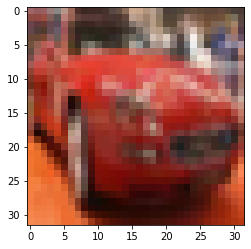

In [11]:
plt.figure()
plt.imshow(train_images[5])
plt.grid(False)
plt.show()

On normalise entre 0 et 1 avant de les transmettre aux différents modèles. Pour ce faire, on divise les valeurs par 255. Il est important que l'ensemble des données d'apprentissage et l'ensemble des données de test soient prétraitées de la même manière:

In [12]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Pour vérifier que les données sont au bon format et qu'on soit prêt à créer et à entraîner nos modèles, affichons les 25 premières images de l'ensemble d'entraînement et affichons le nom de la classe sous chaque image.

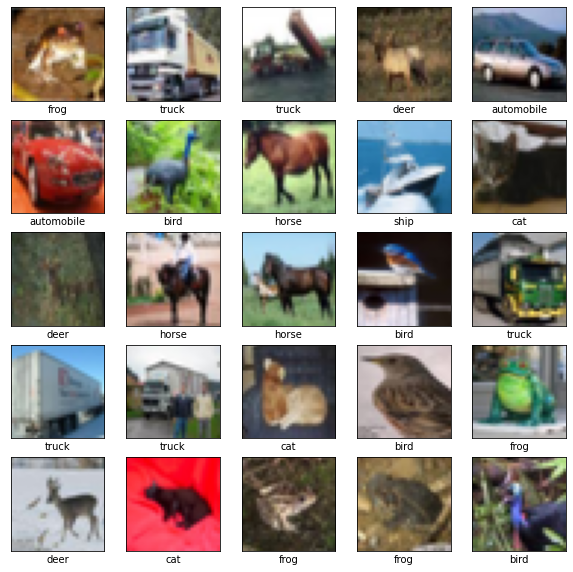

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Construire les modèles

La construction des modèles nécessite la configuration des couches des modèles, puis la compilation des modèles.

### Configuration des couches

Le bloc de construction de base d'un modèle est la couche. Les couches extraient des représentations des données qui y sont introduites. Espérons que ces représentations soient significatives pour le problème en question.

#### Modèle Linéaire

In [14]:
def linear_model():
    model = keras.models.Sequential()
    #Couche de sortie
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

#### Perceptron Multicouches

In [15]:
def pmc_model(nb_couches_cachees, taille_couche, activation='relu', regu=None):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten())
    # couches cachées
    for i in range(nb_couches_cachees):
        model.add(keras.layers.Dense(taille_couche[i], activation = activation, activity_regularizer=regu))
    #Couche de sortie
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

#### Conv Net

In [16]:
def convnet_model(nb_bloc, taille_couche, dropout, activation, regu=None):
    model = keras.models.Sequential()
    for i in range(nb_bloc):
        # premier bloc
        if i == 0:
            model.add(keras.layers.Conv2D(taille_couche[i], (3, 3), input_shape=(32, 32, 3), padding='same', activation=activation, activity_regularizer=regu))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Conv2D(taille_couche[i], (3, 3), padding='same', activation=activation))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
            model.add(keras.layers.Dropout(dropout[i]))
        # les blocs suivants
        else:
            model.add(keras.layers.Conv2D(taille_couche[i], (3, 3), padding='same', activation=activation, activity_regularizer=regu))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Conv2D(taille_couche[i], (3, 3), padding='same', activation=activation))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
            model.add(keras.layers.Dropout(dropout[i]))
    #Couche de sortie
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

#### L'ensemble des modèles

In [17]:
architectures = [] # liste contenant les noms des modèles (avec paramètre)
models = [] # liste contenant tous les modèles qu'on va étudier

In [18]:
models.append(linear_model()) # ajout du modèle linéaire
architectures.append('linéaire') # ajout du modèle linéaire

In [19]:
# PERCEPTRON MULTICOUCHE
nb_couche = [2] # variation de nombre de couches
taille_couche = [
    [256,512]
] # taille de chaque couche

# ajout des modèles perceptron multicouche avec différents paramètres
for current_couche, current_taille in zip(nb_couche, taille_couche):
    models.append(pmc_model(current_couche, current_taille, 'relu', None))
    architectures.append('perceptron multicouche (nb_couches: '+str(current_couche)+' - taille: '+str(current_taille)+' - Pas de regularisation)')

In [20]:
# CONV NETS
nb_bloc = [3] # variation du nombre de mini-bloc
taille_couche = [
    [32,64,128]
] # taille de chaque couche
dropout = [
    [0.2,0.3,0.4]
] # variation du dropout

# ajout des modèles Conv Net avec différents paramètres
for current_bloc, current_taille, current_dropout in zip(nb_bloc, taille_couche, dropout):
    models.append(convnet_model(current_bloc, current_taille, current_dropout, 'relu', None))
    architectures.append('Conv Net (nb_couches: '+str(current_bloc)+' - taille : '+str(current_taille)+' - dropout:'+str(current_dropout)+' - Pas de regularisation)')

L'ensembles des modèles qu'on étudie :

In [21]:
architectures

['linéaire',
 'perceptron multicouche (nb_couches: 2 - taille: [256, 512] - Pas de regularisation)',
 'Conv Net (nb_couches: 3 - taille : [32, 64, 128] - dropout:[0.2, 0.3, 0.4] - Pas de regularisation)']

In [22]:
architectures2 = ['linéaire', 'pmc2_64-128', 'ConvNet3_32-64-128']

### Compilation des modèles

Avant que le modèle ne soit prêt pour l'entraînement, il a besoin de quelques paramètres supplémentaires. Ceux-ci sont ajoutés lors de l'étape de compilation du modèle:

* Fonction de perte - Cela mesure la précision du modèle pendant l'entraînement. Nous voulons minimiser cette fonction pour "diriger" le modèle dans la bonne direction.

* Optimiseur - c'est ainsi que le modèle est mis à jour en fonction des données qu'il voit et de sa fonction de perte.

* Métriques - utilisées pour surveiller les étapes de formation et de test. L'exemple suivant utilise la précision , la portion des images correctement classées.

In [23]:
# COMPILATION DE TOUS NOS MODELES
for model in models:
    model.compile(
        optimizer='adam', #default
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

## Entrainer les modèles
La formation du modèle de réseau neuronal nécessite les étapes suivantes:

1. Envoyer les données d'entraînement au modèle. Dans cet exemple, les données d'apprentissage sont `train_images` et `train_labels`.
2. Le modèle apprend à associer des images aux étiquettes.
3. Nous demandons au modèle de faire des prédictions sur un jeu de test - dans cet exemple `test_images`.
4. Vérifier que les prédictions correspondent aux étiquettes du `test_labels`.


### Entrainement des modèles

In [24]:
# AFFICHAGE DE TENSORBOARD
# %reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost

In [25]:
# CREATION DE PARAMETRE POUR NOUS AIDER
epochs = 250
batch_size = 1000
nb_experience = 5
seed = 0
np.random.seed = seed
tf.random.set_seed(seed)

Pour commencer l'entraînement, on appelle la méthode `model.fit`.

In [26]:
list_model_trained = [] # liste contenant nos modèles entrainés
list_fit_trained = []# liste contenant l'historique des entrainements

for index_models in range(len(models)): # on parcourt tous les modèles
    list_experience = []
    list_experience2 = []
    for current_experience in range(nb_experience): # on entraine notre modèle plusieur fois (nb_experience fois)
        seed += 1 # set de seed
        tf.random.set_seed(seed) # set de seed
        np.random.seed = seed # set de seed
        # save l'historique en fichier
        log_dir = "logs/fit/" + str(architectures2[index_models]) +"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        # entrainement du modèle
        list_experience.append(models[index_models].fit(train_images, train_labels, 
                                                         validation_data = (test_images, test_labels), 
                                                         epochs=epochs, batch_size=batch_size, 
                                                         callbacks=[tensorboard_callback], verbose=0))
        list_experience2.append(models[index_models])
    list_model_trained.append(list_experience2)  
    list_fit_trained.append(list_experience)

### Evaluer la précision

Ensuite, on compare les performances des modèles sur l'ensemble des données de test:

#### Linéaire

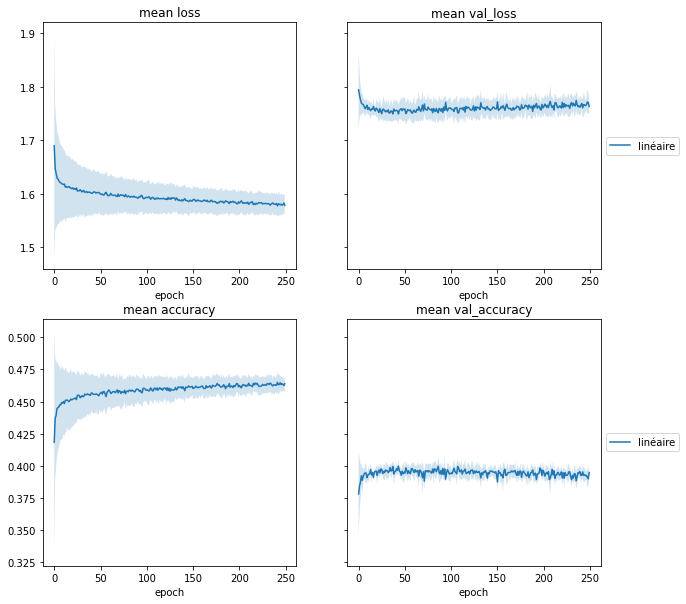

In [27]:
tools_plot.plot_logs2(list_fit_trained[:][:1], architectures[:1])

#### Perceptron Multicouches

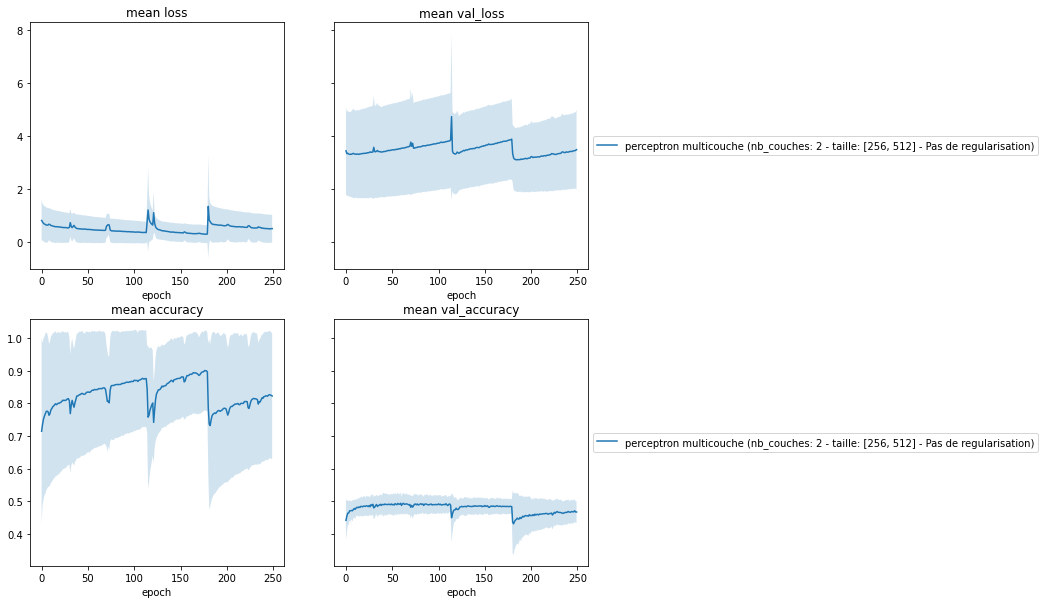

In [28]:
tools_plot.plot_logs2(list_fit_trained[:][1:2], architectures[1:2])

#### Conv Nets

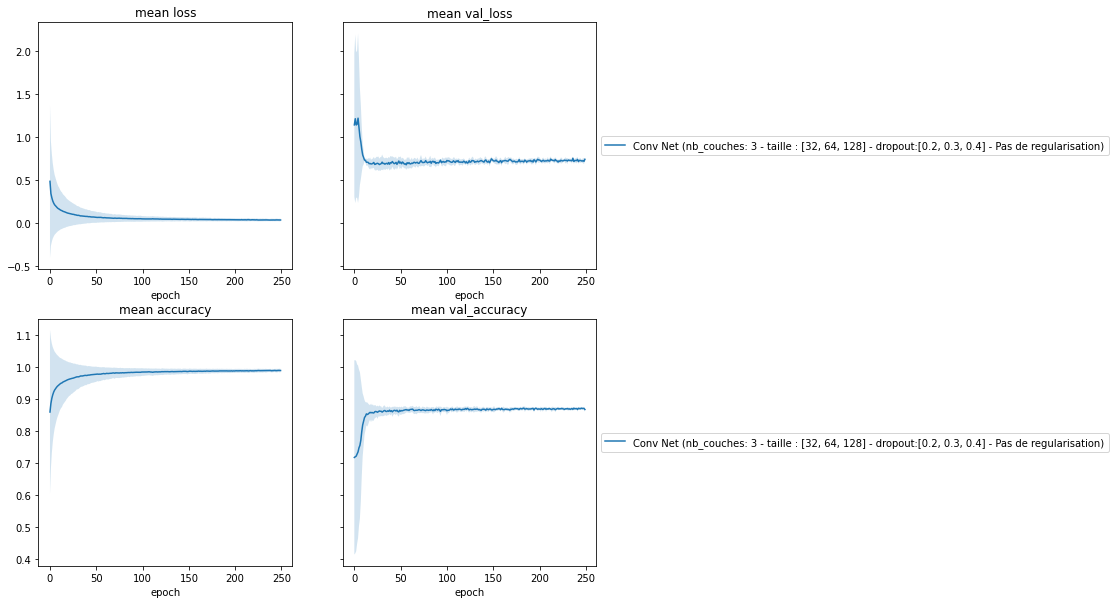

In [29]:
tools_plot.plot_logs2(list_fit_trained[:][2:], architectures[2:])

In [30]:
for index in range(len(models)):
    print("\nModèle :", architectures[index])
    test_loss, test_acc = models[index].evaluate(test_images, test_labels, verbose=2)


Modèle : linéaire
313/313 - 1s - loss: 1.7830 - accuracy: 0.3857

Modèle : perceptron multicouche (nb_couches: 2 - taille: [256, 512] - Pas de regularisation)
313/313 - 1s - loss: 2.3776 - accuracy: 0.4339

Modèle : Conv Net (nb_couches: 3 - taille : [32, 64, 128] - dropout:[0.2, 0.3, 0.4] - Pas de regularisation)
313/313 - 2s - loss: 0.7492 - accuracy: 0.8721


### Faire une prédiction

Avec les modèles entraînés, on attache une couche softmax pour convertir les logits en probabilités, qui sont plus faciles à interpréter.

Une prédiction est un tableau de 10 nombres. Ils représentent la «confiance» du modèle pour que l'image corresponde à chacune des 10 étiquettes. On peut voir quelle étiquette a la valeur de confiance la plus élevée:

In [31]:
predictions = models[index].predict(test_images)
print("\nModèle :", architectures[index])
print("Tableau de prédiction sur une image avec le modèle :")
print(predictions[0])
print("Prédiction (l'étiquette qui a la valeur la plus élevée) :", np.argmax(predictions[0]))
print("Etiquette correcte :", test_labels[0])


Modèle : Conv Net (nb_couches: 3 - taille : [32, 64, 128] - dropout:[0.2, 0.3, 0.4] - Pas de regularisation)
Tableau de prédiction sur une image avec le modèle :
[5.2953281e-15 6.7712295e-14 7.9711689e-11 9.9995863e-01 2.5726204e-13
 4.1386713e-05 8.2322726e-10 1.3387001e-15 1.8364834e-17 3.2282244e-16]
Prédiction (l'étiquette qui a la valeur la plus élevée) : 3
Etiquette correcte : 3


### Vérifier les modèles
On répresente graphiquement pour voir l'ensemble complet des 10 prédictions de classe.

Modélisons les différentes prédictions de chaque classe selon les modèles. Notez que le modèle peut se tromper même lorsqu'il est très confiant.

Les prédictions correctes sont en bleu et les prédictions incorrectes en rouge.


Modèle : linéaire


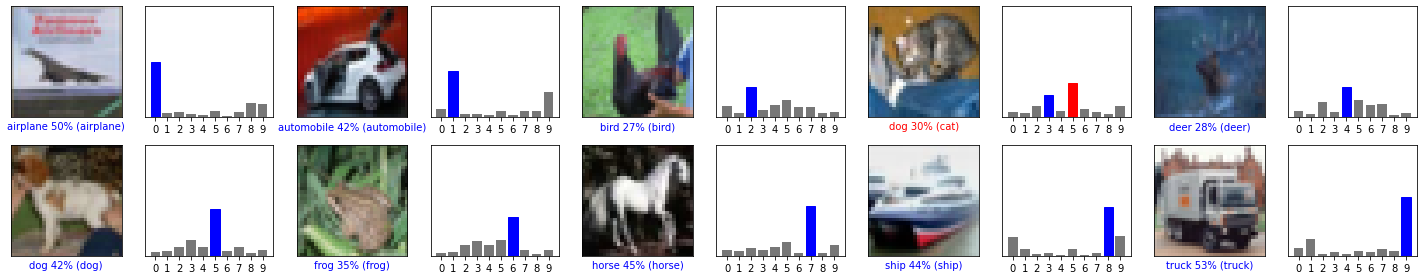


Modèle : perceptron multicouche (nb_couches: 2 - taille: [256, 512] - Pas de regularisation)


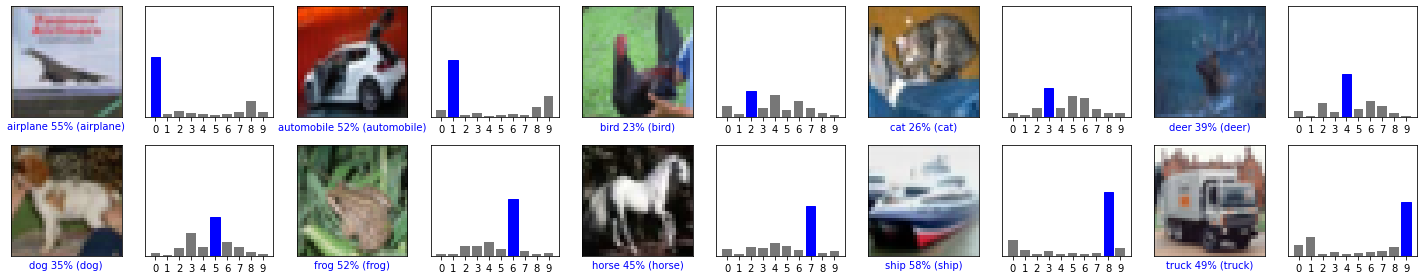


Modèle : Conv Net (nb_couches: 3 - taille : [32, 64, 128] - dropout:[0.2, 0.3, 0.4] - Pas de regularisation)


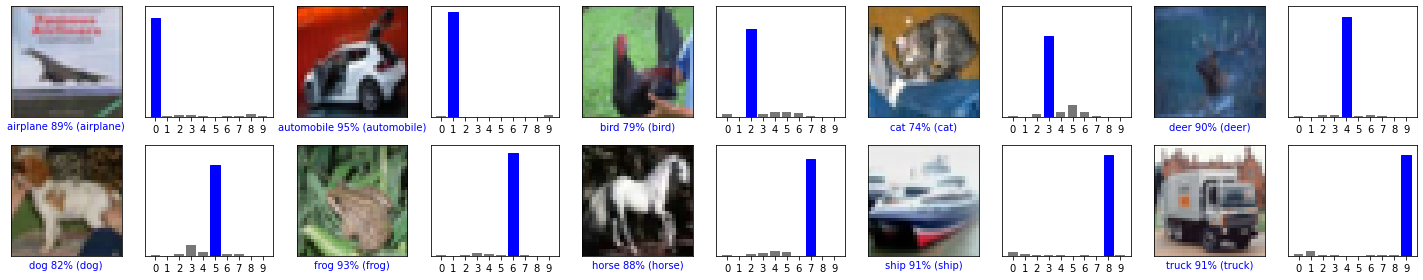

In [32]:
for index in range(len(models)):
    predictions = models[index].predict(test_images)
    print("\nModèle :", architectures[index])
    tools_plot.full_plot2(predictions, test_images, test_labels)

In [33]:
for index in range(len(models)):
    models[index].save(architectures2[index]+str(index)+".h5")

# Nos Runs

## Perceptron Multicouche

### Variation nombres de couches

![](pmc_dif_couche.png)

-   Nombre de couche à limiter
-   Mauvaise adaptation du modèle

### Variation taille des couches

![titre](pmc2_dif_taille.png)

-   Plus de variable = Meilleur modèle
-   Mauvaise adaptation du modèle

![titre](pmc10_dif_taille.png)

-   L'initialisation est un facteur important quand il y a beaucoup de variation de taille
-   L'adaptation est meilleure qu'avant

### Regularisation + Augmentation des données

![titre](pmc_regu.png)

-   Uniquement avec la regularisation, le modèle n'apprend pas
-   Regularisation + Augmention des données, c'est bien mais c'est long

## Conv Nets

### Variation nombres de couches

![titre](cv_dif_couche.png)

-   Plus on a de couche, mieux le modèle se comporte
-   Overfitting présent, test = 100%

### Variation taille des couches

![titre](cv3_dif_taille.png)

-   La taille des couches n'est pas un facteur décisif
-   Overfitting toujours présent

![titre](cv4_dif_taille.png)

-   La taille des couches n'est pas un facteur décisif
-   Overfitting toujours présent